In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.gbp import GuidedBridgeProcess
from neuralbridge.networks.score_net import ScoreNet
from neuralbridge.utils.model import NeuralBridge
from neuralbridge.utils.plotting import plot_sample_path

# Guiding conditional cell diffusion process
We now exam a cell differentiation and development model from _Quantifying the Waddington landscape and biological paths for development and differentiation. Wang et.al._, which is a two-dimensional diffusion process governed by the pair of 1D SDEs:
$$
\mathrm{d}X_{t,1} = \left\{\frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} + \frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} - X_{t,1}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,1} \\
\mathrm{d}X_{t,2} = \left\{\frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} + \frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} - X_{t,2}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a highly nonlinear process with no closed-form solution of conditional bridges. We choose the linear auxiliary process as:
$$
\mathrm{d}\tilde{X}_{t,1} = - \tilde{X}_{t,1}\mathrm{d}t + \sigma\mathrm{d}W_{t,1}\\
\mathrm{d}\tilde{X}_{t,2} = - \tilde{X}_{t,2}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a 2D Ornstein-Uhlenbeck process.

In [3]:
dim = 2
T = 4.0
dt = 1.0 / 100
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

seed = 42
u = jnp.array([0.1, -0.1], dtype=dtype)
v = jnp.array([2.0, -0.1], dtype=dtype)
# v = jnp.array([1.0, -0.1], dtype=dtype) # probably rare event

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [4]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
ori_proc = CellDiffusionProcess(alpha, sigma, T, dim, dtype)
aux_proc = CellDiffusionAuxProcess(alpha, sigma, T, dim, dtype)

guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

ori_solver = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver = Euler(sde=aux_proc, wiener=wiener_proc)
guided_bridge_solver = Euler(sde=guided_proc, wiener=wiener_proc)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}, xlabel='$t$', ylabel='$x$'>

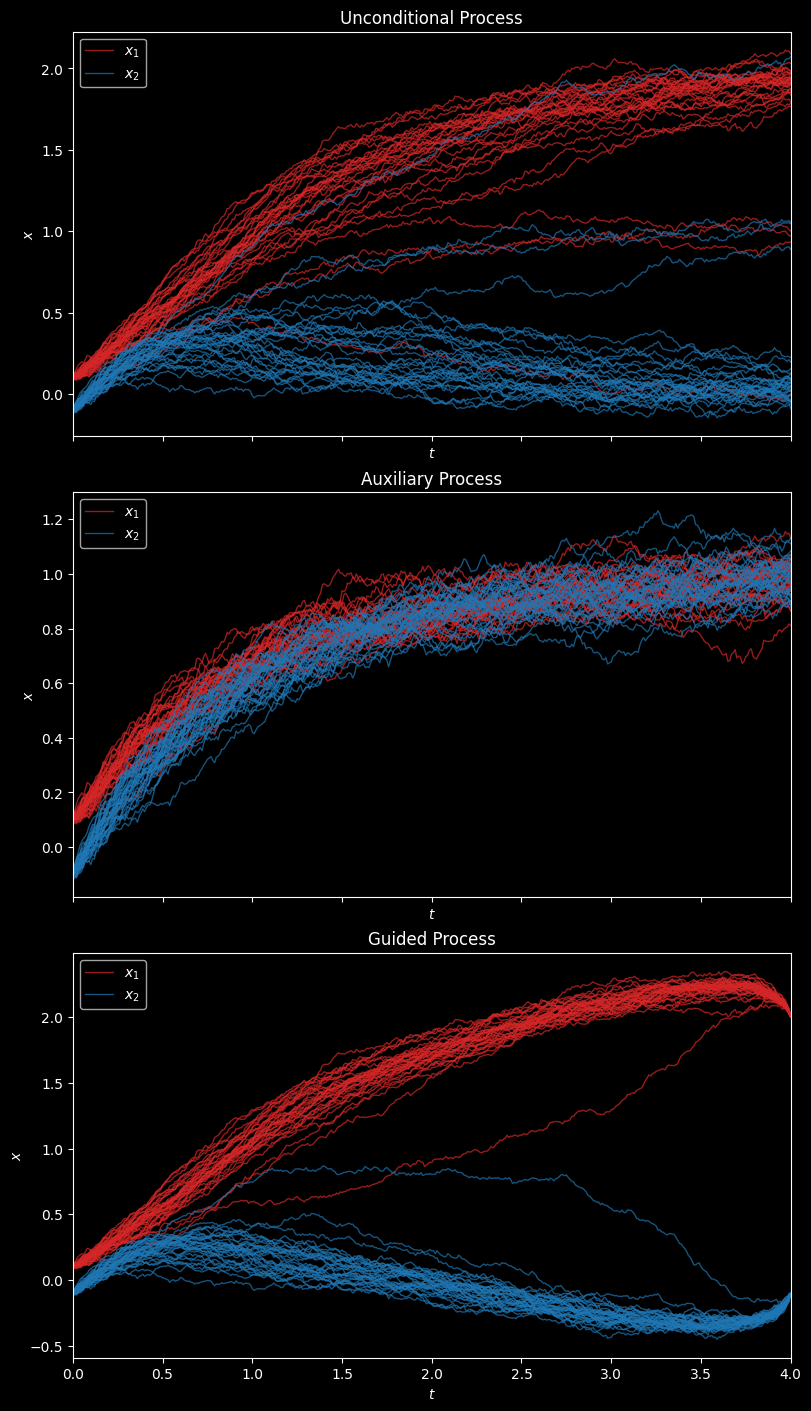

In [5]:
batch_size = 32
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
guided_bridge_path = guided_bridge_solver.solve(x0=u, 
                                                rng_key=rng_key, 
                                                batch_size=batch_size, 
                                                enforce_end_point=v,
                                                bound_log_ll=True
                                            )

fig, axes = plt.subplots(3, 1, figsize=(8, 14), layout="constrained", sharex=True)
plot_sample_path(ori_path, ax=axes[0], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Unconditional Process")
plot_sample_path(aux_path, ax=axes[1], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Auxiliary Process")
plot_sample_path(guided_bridge_path, ax=axes[2], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Guided Process")

In [6]:
net = ScoreNet(out_dim=dim, 
               hidden_dims=(32, 64, 32),
               norm="batch",
               t_emb_dim=32,
               t_emb_max_period=100.0,
               t_emb_scaling=100.0)

In [7]:
train_config = {
    "save_name": "cell_model_normalized_ll",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 128,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [8]:
model = NeuralBridge(guided_proc, net, train_config)

In [9]:
model.init_path_solver(wiener_proc)
losses = model.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -0.01753
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_1


Epoch 2:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -0.02474
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_2


Epoch 3:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -0.02547
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_3


Epoch 4:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -0.02511
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_4


Epoch 5:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -0.02541
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_5


Epoch 6:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -0.02545
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_6


Epoch 7:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -0.02507
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_7


Epoch 8:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -0.02554
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_8


Epoch 9:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -0.02501
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_9


Epoch 10:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -0.02538
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/cell_model_normalized_ll/epoch_10


In [10]:
neural_bridge = model.build_neural_bridge()

<Axes: title={'center': 'Neural Bridge'}, xlabel='$t$', ylabel='$x$'>

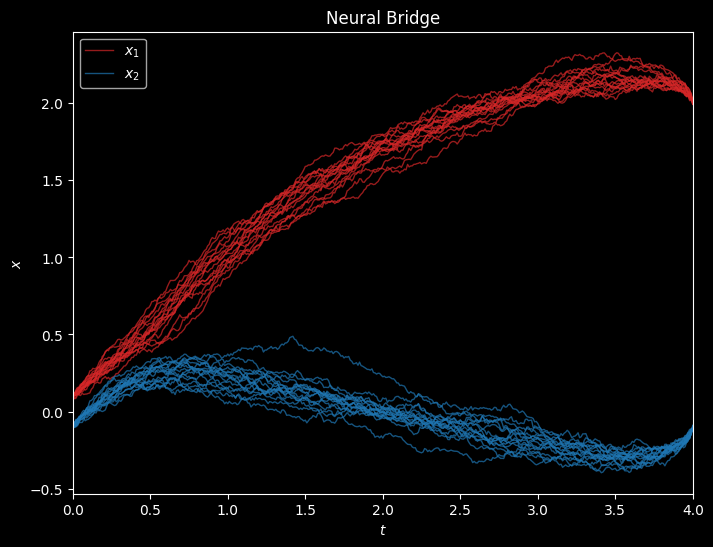

In [11]:
neural_bridge_solver = Euler(neural_bridge, wiener_proc)
neural_bridge_path = neural_bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_sample_path(neural_bridge_path, ax=ax, color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Neural Bridge")